# LIME-Aleph

### KI-Campus Aufgabe

Willkommen zum Arbeitsauftrag für das Modul __LIME-Aleph__ im KI-Campus. Hier werden Sie den typischen Ablauf zum Finden einer symbolischen Erklärung für Black-Box Netzwerke mithilfe der LIME-Aleph Bibliothek Stück für Stück erarbeiten.

In [1]:
from platform import python_version

print(python_version())

3.7.9


In [2]:
pip freeze

absl-py @ file:///C:/ci/absl-py_1603893176799/work
aiohttp @ file:///C:/ci/aiohttp_1602530358780/work
appdirs @ file:///home/conda/feedstock_root/build_artifacts/appdirs_1603108395799/work
argon2-cffi @ file:///C:/ci/argon2-cffi_1596828549974/work
astor==0.8.1
async-generator==1.10
async-timeout==3.0.1
attrs @ file:///tmp/build/80754af9/attrs_1604765588209/work
backcall==0.2.0
bleach @ file:///tmp/build/80754af9/bleach_1600439572647/work
blinker==1.4
brotlipy==0.7.0
cachetools @ file:///tmp/build/80754af9/cachetools_1596822027882/work
certifi==2020.12.5
cffi @ file:///C:/ci/cffi_1605538148575/work
chardet @ file:///C:/ci/chardet_1605303259695/work
click==7.1.2
cloudpickle @ file:///tmp/build/80754af9/cloudpickle_1598884132938/work
colorama @ file:///tmp/build/80754af9/colorama_1603211150991/work
cryptography @ file:///C:/ci/cryptography_1605544557248/work
cycler==0.10.0
cytoolz==0.11.0
dask @ file:///tmp/build/80754af9/dask-core_1602083700509/work
decorator==4.4.2
defusedxml==0.6.0
ent

Wir wollen zunächst mal die nötigen Bibliotheken importieren und einige nutzerdefinierbare Parameter erzeugen. Eine zu klassifizierende Bilddatei sowie ein vortrainiertes Modell sind schon vorhanden.

In [3]:
from ipywidgets import IntProgress

In [4]:
import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
from skimage.util import img_as_float32
from skimage.transform import resize
from scripts.train_model import own_rel
from skimage import io
from skimage.io import imshow, show, imsave
import shutil

import lime_aleph.lime_aleph as la

#NOTEBOOK_PATH = "notebooks/" #
IMAGE_FILE = "pos9000.png" # The path to the image file to be classified by the black-box
MODEL = "../models_to_explain/model_tower.h5" # The path to the pre-trained model
K = 3 # The number of important superpixels to be used for perturbation
N = 1000 # The sample size for LIME
OUTPUT_DIR = "../output/" # A path for a directory to save intermediate and output data
T = 0.8 # The threshold for the binary classifier for when an example is classified as 'positive'
NOISE = 10 # The allowed false-positive rate for Aleph in percent.b

Sollte es noch temporäre Daten aus früheren Durchläufen geben, sollen diese nun gelöscht werden:

In [5]:
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
os.makedirs(OUTPUT_DIR)

Nun wollen wir das Bild und das vortrainierte Modell in den Speicher laden:

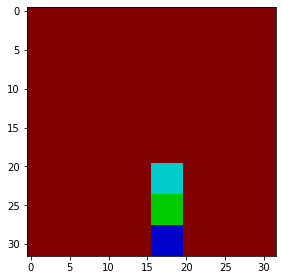

In [6]:
image = img_as_float32(io.imread(IMAGE_FILE))
image = resize(image, (own_rel.IMAGE_SIZE, own_rel.IMAGE_SIZE), anti_aliasing=True)

model = own_rel.own_rel()
model.load_weights(MODEL)

io.imshow(image)
io.show()

Der nächste Schritt soll nun sein, die im Bild vorhandenen Elemente automatisch zu annotieren. Benutzen Sie hierfür die Funktion __annotate_image_parts__ aus dem bereits importierten __lime_aleph__ package mit den benötigten Parametern:

In [7]:
#[SOLUTION]

annotated_image = la.annotate_image_parts(image, model, OUTPUT_DIR, N)

Running LIME...
True class of the image is:  1
Starting the explanation generation process. This may take a while.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.



Intercept -0.15828873356506978
Prediction_local [0.26266126]
Right: 0.023822423
Intercept 1.1582887386165368
Prediction_local [0.73733874]
Right: 0.9761776
Number of superpixels: 64
Annotating the superpixels...
Weight of sp:  52 is:  0.10579369121942299
Weight of sp:  44 is:  0.10356909686558469
Weight of sp:  60 is:  0.10076069912361062
Weight of sp:  21 is:  -0.044907893471481275
Weight of sp:  58 is:  -0.04318624307283063
Weight of sp:  28 is:  -0.03976570206776833
Weight of sp:  26 is:  -0.03318699139770062
Weight of sp:  8 is:  -0.03092985454735343
Weight of sp:  53 is:  -0.029520982356985973
Weight of sp:  61 is:  -0.028745232786424643
Weight of sp:  45 is:  -0.02686456721817619
Weight of sp:  24 is:  0.026761513545965055
Weight of sp:  17 is:  -0.02569892414424742
Weight of sp:  33 is:  -0.02510924639947093
Weight of sp:  51 is:  -0.024824347746291556
Weight of sp:  13 is:  -0.024618440395164327
Weight of sp:  23 is:  -0.0230372302689836
Weight of sp:  47 is:  -0.0226473213838

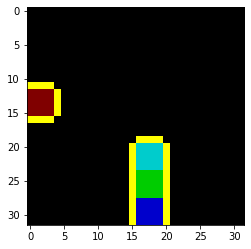

In [8]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

true_class = 1

temp, mask = annotated_image.explanation.get_image_and_mask(true_class, positive_only=True, num_features=4, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

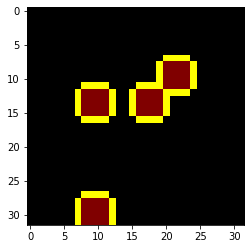

In [9]:
negative_class = 0

temp, mask = annotated_image.explanation.get_image_and_mask(negative_class, positive_only=True, num_features=4, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

Nachdem das Bild nun annotiert ist (als Annotation wurden auch die Gewichte von LIME für die einzelnen Elemente gefunden), können wir nun die wichtigsten __K__ Bildelemente mit der Funktion __find_important_parts__ finden. Anschließend können Sie auch die Relationen zwischen den Bildteilen mit der Funktion __find_spatial_relations__ finden lassen:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


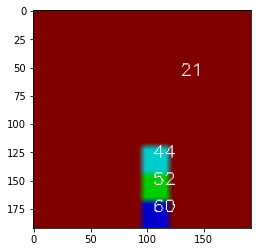

In [10]:
#[SOLUTION]

important_superpixels, labeled_image = la.find_important_parts(annotated_image, 4)

plt.imshow(labeled_image)

In [11]:
relations = la.find_spatial_relations(important_superpixels)

Currently at superpixel 52
Currently at superpixel 44
Currently at superpixel 60
Currently at superpixel 21


Die Liste, welche von der Funktion zum Finden von Relationen zurückgegeben wurde, beinhaltet Objekte vom Typ __Relation__. Hier geben wir nun beispielhaft die Informationen der ersten Relation aus. Natürlich müssen Sie den Namen der Liste an Ihre Implementation anpassen.

In [12]:
for r in relations:
    print(r) 

Relation: 44 -- on --> 52
Relation: 44 -- top_of --> 52
Relation: 60 -- under --> 52
Relation: 60 -- bottom_of --> 52
Relation: 21 -- top_of --> 52
Relation: 52 -- under --> 44
Relation: 52 -- bottom_of --> 44
Relation: 60 -- bottom_of --> 44
Relation: 21 -- top_of --> 44
Relation: 52 -- on --> 60
Relation: 52 -- top_of --> 60
Relation: 44 -- top_of --> 60
Relation: 21 -- top_of --> 60
Relation: 52 -- bottom_of --> 21
Relation: 44 -- bottom_of --> 21
Relation: 60 -- bottom_of --> 21


Der Name beschreibt das Prädikat der räumlichen Relation. Die weiteren Informationen beschreiben die Indices der Start- und Zielelemente der Relation innerhalb des Bildes.

Nun wollen wir das perturbierte Datenset für LIME-Aleph generieren lassen. Benutzen Sie hierzu die Funktion __perturb_instance__ mit den erforderlichen Parametern. Lassen Sie sich auch ausgeben, wie viele Instanzen im neuen Datenset sind (Es wird eine Liste mit Instanzen zurückgegeben).

In [ ]:
#[SOLUTION]
perturbed_dataset = la.perturb_instance(annotated_image, relations, model, T)
print("Number of perturbed instances:", len(perturbed_dataset))

In [ ]:
for idx in annotated_image.superpixels:
    print(vars(idx))

Das ILP-Framework Aleph benötigt mehrere Hilfsdateien, die mit der Funktion __write_aleph_files__ erzeugt werden. Rufen Sie diese Funktion auf. Es sollen alle räumlichen Relationen verwendet werden! Zur Verfügung stehen folgende Relationen: *left_of*, *right_of*, *top_of*, *bottom_of*, *on*, *under*

In [ ]:
#[SOLUTION]
used_relations = None # 'None' if you want to allow all relations, otherwise list with following possibilities: ["left_of", "right_of", "top_of", "bottom_of", "on", "under"]
la.write_aleph_files(annotated_image, perturbed_dataset, used_relations, OUTPUT_DIR, NOISE)

Schlussendlich muss nun der Induktionsprozess von Aleph angestoßen werden. Dieser Schritt (mit der Funktion __run_aleph__) gibt auch die gefundene Erklärung aus:

In [ ]:
#[SOLUTION]
la.run_aleph(OUTPUT_DIR)

Die Erklärung in Form von Regeln kann nun im angegebenen Ordner in der Datei *explanation.txt* gefunden und interpretiert werden. Wir lesen nun diese Datei aus:

In [ ]:
with open(OUTPUT_DIR + "explanation.txt", 'r') as f:
    print(f.read())

# Interpretation 
...


true_class(A) :-
   contains(B,A), has_color(B,mediumblue), contains(C,A), has_color(C,lime), 
   top_of_in_ex(C,B,A).

## Interpretierte Regel

true_class(Turm) :-
   contains(Blau,Turm), has_color(Blau,mediumblue), contains(Grün,Turm), has_color(Grün,lime), 
   top_of_in_ex(Grün,Blau,Turm).

übersetzt in Satz
Turm ist wahr wenn gilt: Der blaue Klotz gehört zu einem Turm, ... 

[Bild]




